In [1]:
import numpy as np
import regreg.api as rr
%pylab inline
from sklearn import datasets
iris = datasets.load_iris()
digits = datasets.load_digits()

Populating the interactive namespace from numpy and matplotlib


## Hinge loss

The SVM can be parametrized various ways, one way to write
it as a regression problem is to use the hinge loss:
$$
\ell(r) = \max(1-x, 0)
$$

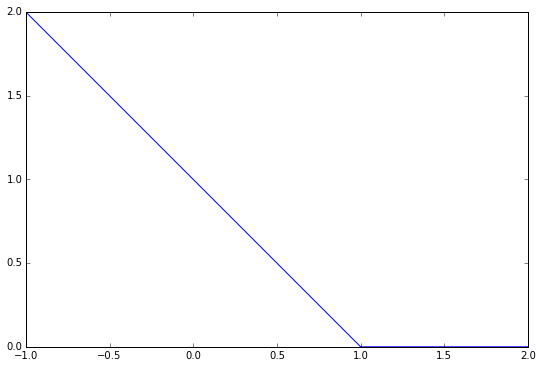

In [2]:
hinge = lambda x: np.maximum(1-x, 0)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
r = np.linspace(-1,2,100)
ax.plot(r, hinge(r))

The SVM loss is then
$$
\ell(\beta) = C \sum_{i=1}^n h(Y_i X_i^T\beta) + \frac{1}{2} \|\beta\|^2_2
)
$$
where $Y_i \in \{-1,1\}$ and $X_i \in \mathbb{R}^p$ is one of the feature vectors. 

In regreg, the hinge loss can be  represented by composition of
some of the basic atoms. Specifcally, let $g:\mathbb{R}^n \rightarrow \mathbb{R}$ be the sum of positive part function
$$
g(z) = \sum_{i=1}^n\max(z_i, 0).
$$
Then,
$$
\ell(\beta) = g\left(Y \cdot X\beta \right)
$$
where the product in the parentheses is elementwise multiplication.

In [3]:
linear_part = np.array([[-1.]])
offset = np.array([1.])
hinge_rep = rr.positive_part.affine(linear_part, offset, lagrange=1.)
hinge_rep

affine_atom(positive_part((1,), lagrange=1.000000, offset=array([-1.])), array([[-1.]]))

Let's plot the loss to be sure it agrees with our original hinge.

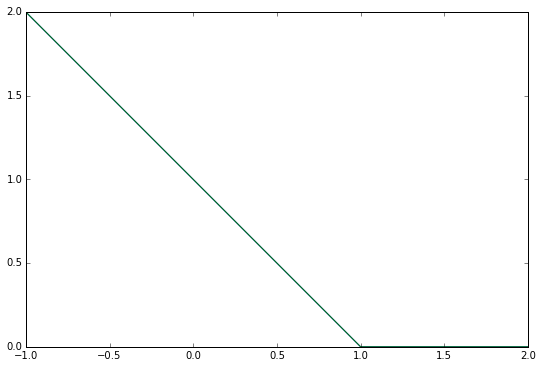

In [4]:
ax.plot(r, [hinge_rep.nonsmooth_objective(v) for v in r])
fig

Here is a vectorized version.

In [5]:
N = 1000
P = 200

Y = 2 * np.random.binomial(1, 0.5, size=(N,)) - 1.
X = np.random.standard_normal((N,P))
#X[Y==1] += np.array([30,-20] + (P-2)*[0])[np.newaxis,:]
X -= X.mean(0)[np.newaxis, :]
hinge_vec = rr.positive_part.affine(-Y[:, None] * X, np.ones_like(Y), lagrange=1.)

In [6]:
beta = np.ones(X.shape[1])
hinge_vec.nonsmooth_objective(beta), np.maximum(1 - Y * X.dot(beta), 0).sum()

(6599.1048464250234, 6599.1048464250234)

## Smoothed hinge

For optimization, the hinge loss is not differentiable so it is often
smoothed first.

The smoothing is applicable to general functions of the form
$$
g(X\beta-\alpha) = g_{\alpha}(X\beta)
$$
where $g_{\alpha}(z) = g(z-\alpha)$ 
and is determined by a small quadratic term
$$
q(z) = \frac{C_0}{2} \|z-x_0\|^2_2 + v_0^Tz + c_0.
$$

In [7]:
epsilon = 0.5
smoothing_quadratic = rr.identity_quadratic(epsilon, 0, 0, 0)
smoothing_quadratic

identity_quadratic(0.500000, 0.0, 0.0, 0.000000)

The quadratic terms are determined by four parameters with $(C_0, x_0, v_0, c_0)$.

Smoothing of the function by the quadratic $q$ is performed by Moreau smoothing:
$$
S(g_{\alpha},q)(\beta) = \sup_{z \in \mathbb{R}^p} z^T\beta - g^*_{\alpha}(z) - q(z)
$$
where
$$
g^*_{\alpha}(z) = \sup_{\beta \in \mathbb{R}^p} z^T\beta - g_{\alpha}(\beta)
$$
is the convex (Fenchel) conjugate of the composition $g$ with the translation by
$-\alpha$.

The basic atoms in `regreg` know what their conjugate is. Our hinge loss, `hinge_rep`,
is the composition of an `atom`, and an affine transform. This affine transform is split
into two pieces, the linear part, stored as `linear_transform` and its offset
stored as `atom.offset`. It is stored with `atom` as `atom` needs knowledge of
this when computing proximal maps.

In [8]:
hinge_rep.atom

positive_part((1,), lagrange=1.000000, offset=array([-1.]))

In [9]:
hinge_rep.atom.offset

array([-1.])

In [10]:
hinge_rep.linear_transform.linear_operator

array([[-1.]])

As we said before, `hinge_rep.atom` knows what its conjugate is

In [11]:
hinge_conj = hinge_rep.atom.conjugate
hinge_conj

constrained_max((1,), bound=1.000000, offset=None, quadratic=identity_quadratic(0.000000, 0.0, array([-1.]), 0.000000))

The notation $I^{\infty}$ denotes a constraint. The expression can therefore be parsed as
a linear function $\eta^T\beta$ plus the function
$$
g^*(z) = \begin{cases}
0 & 0 \leq z_i \leq \delta \, \forall i \\
\infty & \text{otherwise.}
\end{cases}
$$

The term $\eta$ is derived from `hinge_rep.atom.offset` and is stored in `hinge_conj.quadratic`.

In [12]:
hinge_conj.quadratic.linear_term

array([-1.])

Now, let's look at the smoothed hinge loss. 

In [13]:
smoothed_hinge_loss = hinge_rep.smoothed(smoothing_quadratic)
smoothed_hinge_loss

affine_smooth(smooth_conjugate(constrained_max((1,), bound=1.000000, offset=None, quadratic=identity_quadratic(0.500000, 0.0, array([-1.]), 0.000000)),identity_quadratic(0.500000, 0.0, array([-1.]), 0.000000)), <regreg.affine.linear_transform object at 0x7f9066c5fc90>, store_grad=True)

It is now a smooth function and its objective value and gradient can be computed with
`smooth_objective`.

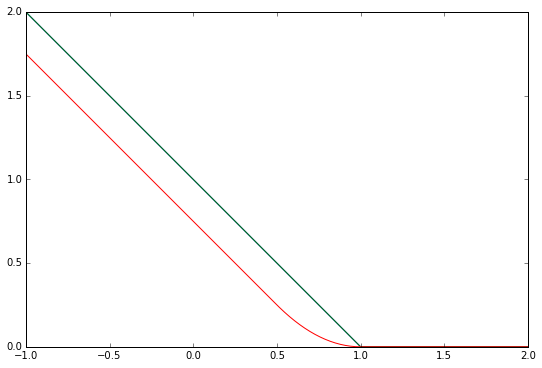

In [14]:
ax.plot(r, [smoothed_hinge_loss.smooth_objective(v, 'func') for v in r])
fig

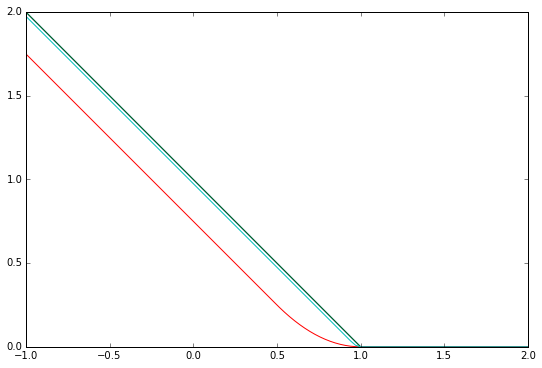

In [15]:
less_smooth = hinge_rep.smoothed(rr.identity_quadratic(5.e-2, 0, 0, 0))
ax.plot(r, [less_smooth.smooth_objective(v, 'func') for v in r])
fig

## Fitting the SVM

We can now minimize this objective.

In [16]:
smoothed_vec = hinge_vec.smoothed(rr.identity_quadratic(0.2, 0, 0, 0))
soln = smoothed_vec.solve(tol=1.e-12, min_its=100)

## Sparse SVM

We might want to fit a sparse version, adding a sparsifying penalty like the LASSO.
This yields the problem
$$
\text{minimize}_{\beta} \ell(\beta) + \lambda \|\beta\|_1
$$

In [17]:
penalty = rr.l1norm(smoothed_vec.shape, lagrange=20)
problem = rr.simple_problem(smoothed_vec, penalty)
problem

In [18]:
sparse_soln = problem.solve(tol=1.e-12)
sparse_soln

array([ 0.03353702, -0.        ,  0.        , -0.02459172,  0.01101475,
        0.        , -0.        ,  0.        ,  0.0200813 , -0.        ,
        0.        ,  0.02844901,  0.        , -0.        , -0.        ,
        0.        , -0.09503251,  0.0187119 ,  0.        ,  0.07615807,
       -0.        , -0.05083342, -0.02587857,  0.05823204, -0.        ,
        0.        , -0.        ,  0.01993363, -0.        , -0.11860564,
       -0.02638528,  0.        ,  0.01076138, -0.0377944 , -0.00954387,
       -0.        , -0.01248638, -0.12345472, -0.        , -0.06456632,
        0.        ,  0.        , -0.00317911, -0.        , -0.        ,
        0.        , -0.03818325, -0.14599191,  0.        , -0.        ,
       -0.        ,  0.05249774, -0.03487935,  0.        , -0.00114244,
       -0.13525279, -0.        , -0.03435325, -0.        , -0.        ,
       -0.        ,  0.1214278 , -0.01045893, -0.07403876, -0.06426707,
       -0.06165469,  0.16648008,  0.        ,  0.        , -0.00

What value of $\lambda$ should we use? For the $\ell_1$ penalty in Lagrange form,
the smallest $\lambda$ such that the solution is zero can be found by taking
the dual norm, the $\ell_{\infty}$ norm, of the gradient of the smooth part at 0.

In [19]:
linf_norm = penalty.conjugate
linf_norm

supnorm((200,), bound=20.000000, offset=None)

Just computing the conjugate will yield an $\ell_{\infty}$ constraint, but this
object can still be used to compute the desired value of $\lambda$.

In [20]:
score_at_zero = smoothed_vec.smooth_objective(np.zeros(smoothed_vec.shape), 'grad')
lam_max = linf_norm.seminorm(score_at_zero, lagrange=1.)
lam_max

109.90892152674274

In [21]:
penalty.lagrange = lam_max * 1.001
problem.solve(tol=1.e-12, min_its=200)

array([ 0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0., -0., -0.,
       -0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,
       -0.,  0., -0., -0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,
       -0., -0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0.,
       -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,
       -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,
        0., -0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
       -0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,
        0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0., -0

In [22]:
penalty.lagrange = lam_max * 0.99
problem.solve(tol=1.e-12, min_its=200)

array([ 0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.  

### Path of solutions

If we want a path of solutions, we can simply take multiples of `lam_max`. This is similar
to the strategy that packages like `glmnet` use

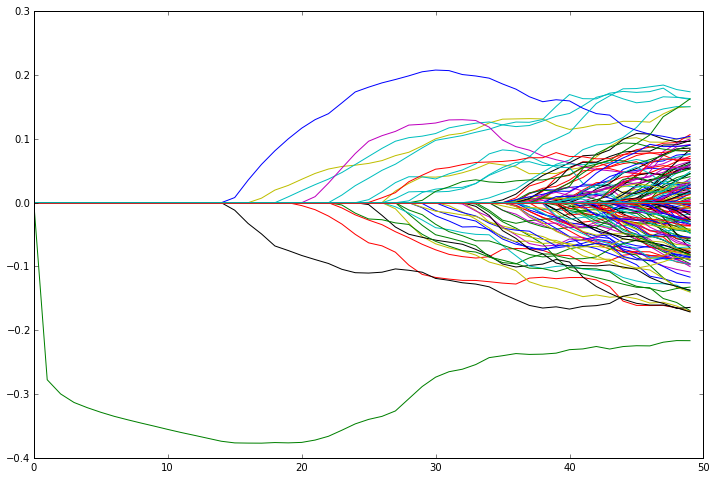

In [23]:
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max)[::-1]
for lam_val in lam_vals:
    penalty.lagrange = lam_val
    path.append(problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

## Changing the penalty

We may not want to penalize features the same. We may want some features to be unpenalized.
This can be achieved by introducing possibly non-zero feature weights to the $\ell_1$ norm
$$
\beta \mapsto \sum_{j=1}^p w_j|\beta_j|
$$



In [24]:
weights = np.random.sample(P) + 1.
weights[:5] = 0.
weighted_penalty = rr.weighted_l1norm(weights, lagrange=1.)
weighted_penalty

l1norm([ 0.          0.          0.          0.          0.          1.82222164
  1.98442424  1.87911449  1.43614334  1.35962615  1.26968398  1.39777835
  1.71889978  1.55459806  1.58954175  1.52504184  1.20997166  1.69164961
  1.81663036  1.09061853  1.38679954  1.09653398  1.71798199  1.23137066
  1.57040792  1.24890752  1.91709269  1.30141417  1.00252736  1.74003862
  1.76069161  1.63634011  1.19826086  1.11745654  1.89414454  1.28892229
  1.77524017  1.03158046  1.09447549  1.53034192  1.42601459  1.70349655
  1.49395318  1.2433236   1.56017588  1.80033615  1.31176991  1.17595555
  1.87328709  1.72557008  1.45278857  1.4680937   1.7668804   1.13291974
  1.79874737  1.70719518  1.77499548  1.76159135  1.2065164   1.9172275
  1.71758848  1.86334211  1.42723903  1.49353672  1.48740017  1.42370946
  1.04340511  1.05340214  1.14362077  1.82750687  1.60291932  1.78037898
  1.62384001  1.10172841  1.90058144  1.14596821  1.62012349  1.92984931
  1.34839335  1.14608553  1.40943434  1.79762

In [25]:
weighted_dual = weighted_penalty.conjugate
weighted_dual

supnorm([        inf         inf         inf         inf         inf  0.54878066
  0.5039245   0.53216555  0.69630932  0.7354963   0.78759755  0.71542101
  0.58176748  0.64325309  0.62911213  0.65571971  0.82646564  0.59113896
  0.55046972  0.91691088  0.72108475  0.91196445  0.58207828  0.81210316
  0.63677723  0.8006998   0.52162319  0.76839489  0.99747901  0.57469989
  0.56795863  0.6111199   0.83454282  0.89488939  0.52794282  0.77584196
  0.56330406  0.96938633  0.91367966  0.65344874  0.7012551   0.5870279
  0.66936502  0.80429584  0.64095338  0.55545183  0.76232881  0.85037228
  0.53382101  0.57951862  0.68833141  0.68115543  0.56596926  0.88267506
  0.55594244  0.5857561   0.56338172  0.56766854  0.8288325   0.52158651
  0.58221164  0.5366701   0.70065348  0.66955166  0.67231403  0.7023905
  0.95840052  0.94930507  0.87441574  0.54719356  0.62386172  0.56167817
  0.61582422  0.90766471  0.52615478  0.87262456  0.6172369   0.51817517
  0.74162335  0.87253523  0.70950449  0.55628

In [26]:
lam_max_weight = weighted_dual.seminorm(score_at_zero, lagrange=1.)
lam_max_weight


73.090415979458243

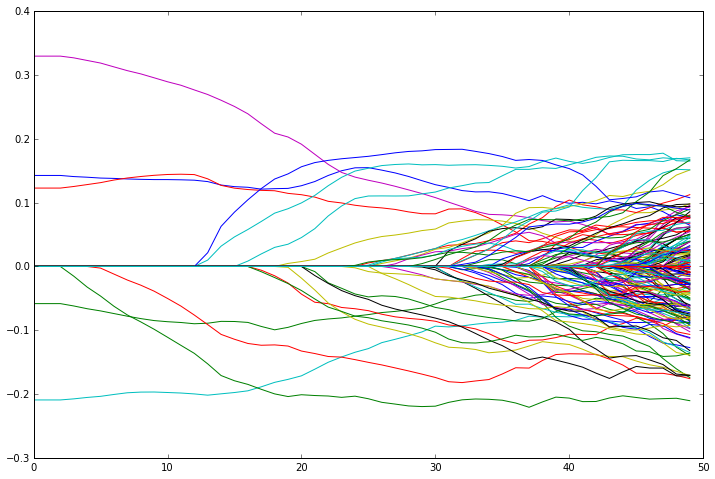

In [27]:
weighted_problem = rr.simple_problem(smoothed_vec, weighted_penalty)
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max_weight)[::-1]
for lam_val in lam_vals:
    weighted_penalty.lagrange = lam_val
    path.append(weighted_problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

Note that there are 5 coefficients that are not penalized hence they are nonzero the entire path.

#### Group LASSO

Variables may come in groups. A common penalty for this setting is the group LASSO.
Let $$
\{1, \dots, p\} = \cup_{g \in G} g
$$
be a partition of the set of features and $w_g$ a weight for each group. The 
group LASSO penalty is
$$
\beta \mapsto \sum_{g \in G} w_g \|\beta_g\|_2.
$$

In [28]:
groups = []
for i in range(P/5):
    groups.extend([i]*5)
weights = dict([g, np.random.sample()+1] for g in np.unique(groups))
group_penalty = rr.group_lasso(groups, weights=weights, lagrange=1.)


In [29]:
group_dual = group_penalty.conjugate
lam_max_group = group_dual.seminorm(score_at_zero, lagrange=1.)

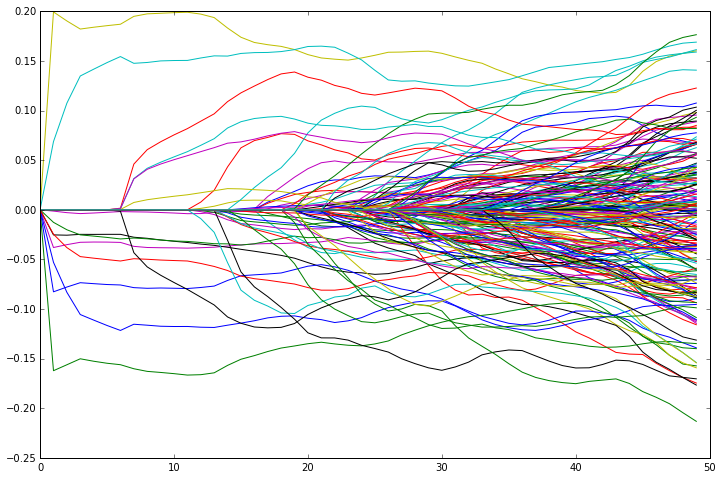

In [30]:
group_problem = rr.simple_problem(smoothed_vec, group_penalty)
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max_group)[::-1]
for lam_val in lam_vals:
    group_penalty.lagrange = lam_val
    path.append(group_problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

As expected, variables enter in groups here.

### Bound form

The common norm atoms also have a bound form. That is, we can just as easily solve the 
problem
$$
\text{minimize}_{\beta: \|\beta\|_1 \leq \delta}\ell(\beta)
$$


In [31]:
bound_l1 = rr.l1norm(P, bound=2.)
bound_l1

l1norm((200,), bound=2.000000, offset=None)

In [32]:
bound_problem = rr.simple_problem(smoothed_vec, bound_l1)
bound_problem

In [33]:
bound_soln = bound_problem.solve()
np.fabs(bound_soln).sum()

2.0